/var/folders/jt/p45yfdkx2nqcxbdvxb2j149w0000gn/T/ipykernel_88355/2721829963.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(etfs, start=start_date, end=end_date)["Close"]
[*********************100%***********************]  7 of 7 completed


Processing pair: XLU & XLRE
Processing pair: VPU & XLRE
Processing pair: SHY & VGSH
Processing pair: ARKK & ARKW

Class Distribution: Counter({1: 1625, 0: 1386})

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       346
           1       0.77      0.78      0.78       407

    accuracy                           0.76       753
   macro avg       0.75      0.75      0.75       753
weighted avg       0.76      0.76      0.76       753


Confusion Matrix:
 [[250  96]
 [ 88 319]]


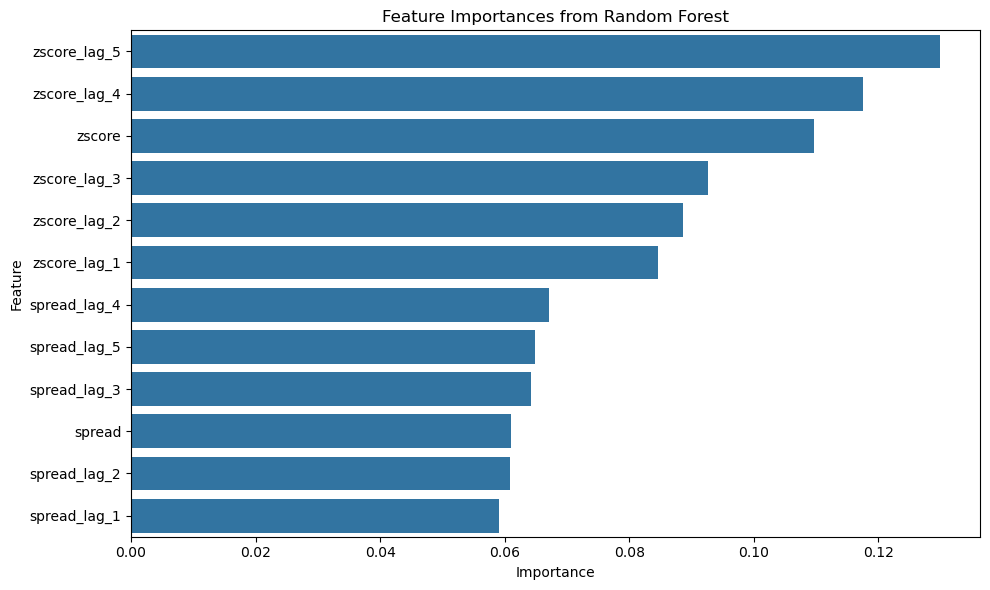

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# -----------------------------
# 1. Define ETF pairs and date range
# -----------------------------
etf_pairs = [
    ('XLU', 'XLRE'),
    ('VPU', 'XLRE'),
    ('SHY', 'VGSH'),
    ('ARKK', 'ARKW')
]

start_date = "2010-01-01"
end_date = "2019-12-31"

# -----------------------------
# 2. Download price data
# -----------------------------
etfs = list(set([etf for pair in etf_pairs for etf in pair]))
price_data = yf.download(etfs, start=start_date, end=end_date)["Close"]
price_data.dropna(inplace=True)

# -----------------------------
# 3. Function to process a pair
# -----------------------------
def process_pair(etf1, etf2, price_data, lookback=60):
    pair_df = pd.DataFrame(index=price_data.index)
    pair_df["etf1"] = price_data[etf1]
    pair_df["etf2"] = price_data[etf2]
    
    # Hedge ratio via rolling OLS
    pair_df["hedge_ratio"] = (
        pair_df["etf1"].rolling(lookback).cov(pair_df["etf2"]) /
        pair_df["etf2"].rolling(lookback).var()
    )
    
    # Spread and z-score
    pair_df["spread"] = pair_df["etf1"] - pair_df["hedge_ratio"] * pair_df["etf2"]
    spread_mean = pair_df["spread"].rolling(lookback).mean()
    spread_std = pair_df["spread"].rolling(lookback).std()
    pair_df["zscore"] = (pair_df["spread"] - spread_mean) / spread_std
    
    # Lag features
    for i in range(1, 6):
        pair_df[f"spread_lag_{i}"] = pair_df["spread"].shift(i)
        pair_df[f"zscore_lag_{i}"] = pair_df["zscore"].shift(i)

    # Define mean reversion target
    pair_df["target"] = (
        (pair_df["zscore"].shift(-1).abs() < pair_df["zscore"].abs()).astype(int)
    )

    # Add pair name
    pair_df["pair"] = f"{etf1}_{etf2}"
    
    return pair_df.dropna()

# -----------------------------
# 4. Process all ETF pairs
# -----------------------------
all_pairs = []
for etf1, etf2 in etf_pairs:
    print(f"Processing pair: {etf1} & {etf2}")
    processed_df = process_pair(etf1, etf2, price_data)
    all_pairs.append(processed_df)

full_df = pd.concat(all_pairs)

# -----------------------------
# 5. Define features and target
# -----------------------------
feature_cols = [
    'spread', 'zscore',
    'spread_lag_1', 'zscore_lag_1',
    'spread_lag_2', 'zscore_lag_2',
    'spread_lag_3', 'zscore_lag_3',
    'spread_lag_4', 'zscore_lag_4',
    'spread_lag_5', 'zscore_lag_5'
]

X = full_df[feature_cols]
y = full_df["target"]

# -----------------------------
# 6. Split data and train model
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nClass Distribution:", Counter(y_train))

rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# -----------------------------
# 7. Predict and evaluate
# -----------------------------
y_pred = rf.predict(X_test)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# -----------------------------
# 8. Feature importance
# -----------------------------
importances = rf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()
